# Evaluacion e implementacion del Modelo
## Macro Average de F1-score
Usaremos con una metrica el ```macro average``` que se calcula como se muestra en la figura. De esta manera podremos usar una sola métrica para medir el rendimiento general del modelo

<img src="images/macro-avg-f1-score.png" class="center" alt="macro avg de f1-score" />

Podemos obtener el ```macro average``` mediante 

```precision_recall_fscore_support(y_test, predictions, average = 'macro')[2]```

## Analisis usando ROC y AUC
- Modelos con mejor performance tendran más Lift, es decir, la curva se alejará más del centro
- Más lift significa que el score de AUC será mayor

## Calibracion del Modelo
Mediremos que tan bien calibradas están las predicciones del modelo.

Lo que esto significa es que queremos que las probabilidades de  ```Default``` representen correctamente el nivel de confianza del modelo
- La probabilidad de ```Default``` tiene un grado de incertidumbre en su prediccion
- Una muestra de prestamos y sus probabilidades de ```default``` predecidas debe ser cercana al porcentage de defaults en esa muestra

<table style="width:100%; align:center; text-align: center">
  <tr>
    <th>Muestra de Prestamos</th>
    <th>Promedio Predicho de PD</th>
    <th>Porcentaje Real de Defaults en la Muestra</th>
    <th>Calibrado?</th>
  </tr>
  <tr>
    <td>10</td>
    <td>0.12</td>
    <td>0.12</td>
    <td>Si</td>
  </tr>
  <tr>
    <td>10</td>
    <td>0.25</td>
    <td>0.65</td>
    <td>No</td>
  </tr>
</table>

En la tabla de arriba de puede ver que en la primera fila para una muestra de 10 prestamos el promedio predicho de los prestamos como defaults es del 12%, el cual coincide con el porcentaje real. En cambio, en la segunda fila el promedio predicho de defaults es de 25%, pero en realidad el 65% de la muestra contiene prestamos con default, por lo que el modelo no está calibrado

Para calcular este valor utilizaremos la funcion ```calibration_curve```. El esta funcion toma como paremetros el test set, las probabildades y ```n_bins``` que representa el numero de muestras a tomar

Llamemos ```PD``` a las probababilidades predichas y ```%Default``` al porcentaje real de ```Defaults``` en la muestra. 
Supongamos que para una de las muestras tenemos los valores:
- ```PD=0.56```
- ```%Default=0.75```

Esto indica que estamos prediciendo menos defaults de los que deberíamos, esto indica varios ```falsos negativos```, lo cual puede afectar negativamente al negocio 

Si ahora para otra muestra tenemos los siguientes valores:
- ```PD=0.94```
- ```%Default=0.66```

En esa muestra encontramos la mayor parte de nuestros falsos positivos. Estas son oportunidades que se pueden perder al predecirlas como default. Pero para este problema resultan menos perjudiciales que los defaults

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, \
                            classification_report, \
                            precision_recall_fscore_support, \
                            roc_auc_score, \
                            confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import matplotlib
import xgboost as xgb
cr_loan_clean = pd.read_csv("data/cr_loan_nout_nmiss.csv")

### Creacion de los conjuntos de entrenamiento y testing

In [2]:
cred_num = cr_loan_clean.select_dtypes(exclude=['object'])
cred_str = cr_loan_clean.select_dtypes(include=['object'])

cred_str_onehot = pd.get_dummies(cred_str)
cr_loan_prep = pd.concat([cred_num, cred_str_onehot], axis=1)

In [3]:
# Separacion de los features y la variable a predecir
columns = list(cr_loan_prep.columns)
X_columns = [column for column in columns if column != 'loan_status']
X = cr_loan_prep[X_columns]
y = cr_loan_prep[['loan_status']]

# Creacion del dataset de entrenamiento y de testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

## Crear Modelos de ```regresion logistica``` y ```gradient boosting trees```

### Logistic Regression

In [4]:
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))
clf_logistic_preds = clf_logistic.predict_proba(X_test)[:,1]
clf_logistic_preds

array([0.4457786 , 0.22344653, 0.28855826, ..., 0.52244951, 0.3704781 ,
       0.12378554])

### GBT

In [5]:
clf_gbt = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))
clf_gbt_preds = clf_gbt.predict_proba(X_test)[:,1]

## Pruebas

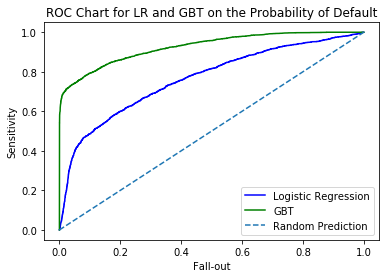

In [6]:
# Componentes del ROC chart
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, clf_logistic_preds)
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, clf_gbt_preds)

# ROC Chart para ambos modelos
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [7]:
# AUC Regresion Logistica
print("Logistic Regression AUC Score: %0.2f" % roc_auc_score(y_test, clf_logistic_preds))

# AUC Gradient Boosting Trees
print("Gradient Boosted Tree AUC Score: %0.2f" % roc_auc_score(y_test, clf_gbt_preds))

Logistic Regression AUC Score: 0.76
Gradient Boosted Tree AUC Score: 0.93


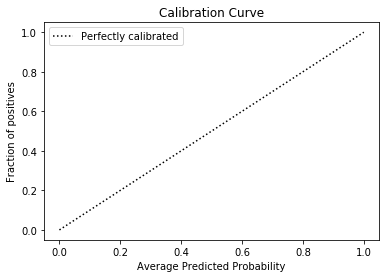

In [8]:
# Creacion de la linea guia para el grafico de la curva de calibracion
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

In [9]:
# calibration_curve??

In [10]:
# Calibration curve para LR
frac_of_pos_lr, mean_pred_val_lr = calibration_curve(y_test, clf_logistic_preds, n_bins=20)

# Calibration curve para GBT
frac_of_pos_gbt, mean_pred_val_gbt = calibration_curve(y_test, clf_gbt_preds, n_bins=20)

## Fracciones y promedios para la curva de calibracion

## Visualizacion de la curva de calibracion

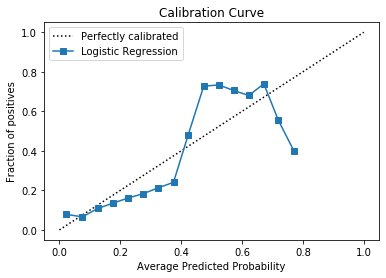

In [11]:
# Se acrega la curva de calibracion para la regresion logistica al grafico
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr,
         's-', label='%s' % 'Logistic Regression')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

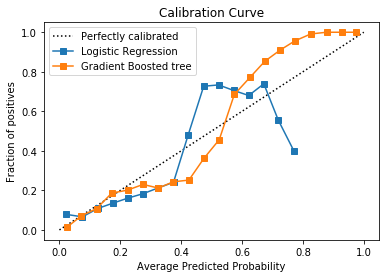

In [12]:
# Se acrega la curva de calibracion para GBT al grafico
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr,
         's-', label='%s' % 'Logistic Regression')
plt.plot(mean_pred_val_gbt, frac_of_pos_gbt,
         's-', label='%s' % 'Gradient Boosted tree')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

# Ratio de Aceptacion de Créditos
Hasta el momento en todos los notebooks desarrollados, usamos ```thresholds``` seleccionados empiricamente o directamente los ```thresholds``` que implementan los modelos por defecto.

Por ejemplo, si elegimos como ```threshold=0.4``` entonces tendriamos lo siguiente:

<table style="width:100%; align:center; text-align: center">
  <tr>
    <th>Prestamo</th>
    <th>Probabilidad de Default</th>
    <th>Threshold</th>
    <th>Status del Prestamo</th>
  </tr>
  <tr>
    <td>1</td>
    <td>0.25</td>
    <td>0.4</td>
    <td>0</td>
  </tr>
  <tr>
    <td>2</td>
    <td>0.42</td>
    <td>0.4</td>
    <td>1</td>
  </tr>
  <tr>
    <td>3</td>
    <td>0.75</td>
    <td>0.4</td>
    <td>1</td>
  </tr>
</table>

Todos los prestamos con probabilidades por debajo de ```0.4``` serían considerados como ```non-defaults``` y los superiores al ```threshold``` serían considerados ```defaults```

Como los modelos ya han calculado las probabilidades, podemos usar estas probabilidades para calcular el ```threshold```. Como el ```threshold``` es utilizado para determinar si la colocacion de un prestamo será un default o no, también puede ser utilizado para aprobar o rechazar nuevos prestamos que llegan. 

A modo de ejemplo asumamos que nuestro conjunto de prueba ```test set``` es un batch de nuevos prestamos. Antes de elegir un nuevo ```threshold``` debemos introducir el concepto de ratio de aceptacion o ```acceptance rate```

```Acceptance Rate```: consiste en el porcentage de prestamos nuevos que aceptamos con el objetivo de mantener el numero de defaults por debajo de cierto número.

Para poder calcular el ```threshold``` para obtener cierto porcentaje de ```acceptance rate``` utilizaremos la funcion ```np.quantile``` de numpy. Esto utiliza nuestro array de probabilidades de default y el ```acceptance rate``` para determinar que valores separan nuestros prestamos aceptados de los rechazados. 

Si por ejemplo ejecutacemos ```threshold = np.quantile(prob_default, 0.85)``` y obtuviesemos como threshold ```0.81``` nuestras predicciones serían:

<table style="width:100%; align:center; text-align: center">
  <tr>
    <th>Prestamo</th>
    <th>prob_default</th>
    <th>Threshold</th>
    <th>Status Predicho</th>
    <th>Aceptar | Rechazar</th>
  </tr>
  <tr>
    <td>1</td>
    <td>0.65</td>
    <td>0.81</td>
    <td>0</td>
    <td>Aceptar</td>
  </tr>
  <tr>
    <td>2</td>
    <td>0.85</td>
    <td>0.81</td>
    <td>1</td>
    <td>Rechazar</td>
  </tr>
</table>

A pesar de que elegimos el nuevo threshold, en nuestro conjunto de prestamos aceptados pueden haber algunos que en realidad serán ```defaults```. Esto se debe a que nuestro modelo no está bien calibrado y al porcentaje de potenciales defaults aceptados lo llamamos ```Bad Rate```

El ```Bad Rate``` se puede calcular de la siguiente manera:

<img src="images/bad-rate.png" class="center" alt="Bad Rate" />

In [13]:
true_loan_status = y_test.rename(columns={'loan_status': 'true_loan_status'}, inplace=False)
test_pred_df = pd.concat([true_loan_status.reset_index(drop=True), 
                              pd.DataFrame(clf_gbt_preds, columns=['prob_default'])],
                             axis=1)
test_pred_df.head()

,true_loan_status,prob_default
0,1,0.940435
1,1,0.922014
2,0,0.021707
3,0,0.026483
4,1,0.064803


In [14]:
print(test_pred_df['prob_default'].describe())

count    11784.000000
mean         0.218806
std          0.300486
min          0.001122
25%          0.038786
50%          0.078899
75%          0.214860
max          0.999459
Name: prob_default, dtype: float64


In [15]:
y_test.head()

,loan_status
28606,1
22585,1
13888,0
3145,0
14882,1


In [16]:
# Calculo de threshold para tener un 0.85 acceptance rate
acceptance_rate = 0.85
threshold = np.quantile(test_pred_df['prob_default'], acceptance_rate)

# Aplicacion del threshold a las probabilidades predichas
test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > threshold else 0)

# Conteo de status de los prestamos luego de aplicar el threshold
print(test_pred_df['pred_loan_status'].value_counts())

0    10016
1     1768
Name: pred_loan_status, dtype: int64


In [17]:
test_pred_df.head()

,true_loan_status,prob_default,pred_loan_status
0,1,0.940435,1
1,1,0.922014,1
2,0,0.021707,0
3,0,0.026483,0
4,1,0.064803,0


### Visualizacion de los cuantiles de aceptacion

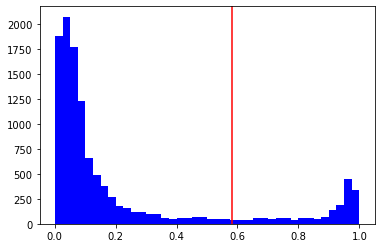

In [18]:
# Plot tde las probabilidades de default predichas
plt.hist(clf_gbt_preds, color = 'blue', bins = 40)

# Calculo del threshold
threshold = np.quantile(clf_gbt_preds, 0.85)

# Linea de referencia para el threshold
plt.axvline(x = threshold, color = 'red')
plt.show()

### Bad Rates

In [19]:
# Subset de prestamos aceptados
accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]

# Calculo del Bad Rate
print(np.sum(accepted_loans['true_loan_status']) / accepted_loans['true_loan_status'].count())

0.08746006389776358


In [20]:
print(X_test['loan_amnt'].describe())

count    11784.000000
mean      9556.283944
std       6238.005674
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12000.000000
max      35000.000000
Name: loan_amnt, dtype: float64


In [21]:
# Store the average loan amount
avg_loan = np.mean(X_test['loan_amnt'])

# Crosstab
print(pd.crosstab(test_pred_df['true_loan_status'],
                 test_pred_df['pred_loan_status']).apply(lambda x: x * avg_loan, axis = 0))

pred_loan_status             0             1
true_loan_status                            
0                 8.734444e+07  5.542645e+05
1                 8.371305e+06  1.634125e+07


# Estrategia de credito y Perdida Mínima Esperada
## Seleccionando un ```Acceptance Rate```
En lugar de elegir un ```Acceptance Rate``` de forma manual como se hizo más arriba, podemos elegirlo de forma automática. Para esto podemos crear una tabla con una serie de ```Acceptance Rate``` que luego seran probados automáticamente. A esta tabla la llamamos tabla estrategica o ```strategy table``` 

## Calculando la tabla de valores

In [22]:
# Ejecutar una vez
test_pred_df = pd.concat([test_pred_df, pd.DataFrame(X_test['loan_amnt']).reset_index(drop=True)], axis=1)

In [23]:
accept_rates = [ i/100 for i in range(101) if (i%5 == 0)]
accept_rates

[0.0,
 0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95,
 1.0]

In [24]:
# Populate the arrays for the strategy table with a for loop
preds_df_gbt = test_pred_df
thresholds, bad_rates = [], []
accepted_loans_list = []
avg_loan_amnts = []
estimated_values = []
for rate in accept_rates:
    # Calculo del threshold para el acceptance rate
    thresh = np.quantile(preds_df_gbt['prob_default'], rate).round(3)
    # Se agrega el valor del threshold a la lista de valores
    thresholds.append(np.quantile(preds_df_gbt['prob_default'], rate).round(3))
    # Se reasigna el valor del loan_stats usando el threshold
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)

    # Se crea un conjunto de loans aceptados usando el acceptance rate
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    # Se calcula el bad rate usando el acceptance rate y se agrega a una lista
    bad_rates.append(np.sum((accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])).round(3))
    
    # Usando los prestamos aceptados, calculamos cuantos de los mismos fueron aceptados
    accepted_loans_list.append(len(accepted_loans['true_loan_status']))
    # Calculamos el promedio de loans 
    avg_amnt = np.mean(accepted_loans['loan_amnt'])
    if (avg_amnt >= 0 or avg_amnt < 0) == False:
        avg_amnt = np.float(0.0)
    avg_loan_amnts.append(avg_amnt)
    
    # Dentro del conjunto de prestamos aceptados
    # Tomamos el conjunto de prestamos que no son defaults
    # y calculamos el valor total de dichos prestamos
    non_default_loans_amnt = np.sum(accepted_loans[accepted_loans['true_loan_status'] == 0 ]['loan_amnt'])
    # Tomamos el conjunto de prestamos que son defaults
    # y calculamos el valor total de dichos prestamos
    default_loans_amnt = np.sum(accepted_loans[accepted_loans['true_loan_status'] == 1 ]['loan_amnt'])
    # Calculamos el valor estimado restando el monto total de prestamos no default
    # menos el valor total de preestamos defaults
    estimated_values.append(non_default_loans_amnt - default_loans_amnt)

In [25]:
# Creamos un dataframe de la tabla estrategica o strategy table
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates),
                        columns = ['Acceptance Rate','Threshold','Bad Rate'])

print(strat_df)

    Acceptance Rate  Threshold  Bad Rate
0              0.00      0.001     0.000
1              0.05      0.008     0.000
2              0.10      0.017     0.002
3              0.15      0.025     0.003
4              0.20      0.032     0.004
5              0.25      0.039     0.009
6              0.30      0.045     0.013
7              0.35      0.053     0.017
8              0.40      0.062     0.023
9              0.45      0.070     0.027
10             0.50      0.079     0.032
11             0.55      0.090     0.037
12             0.60      0.105     0.041
13             0.65      0.128     0.046
14             0.70      0.158     0.052
15             0.75      0.215     0.061
16             0.80      0.330     0.071
17             0.85      0.584     0.088
18             0.90      0.878     0.133
19             0.95      0.962     0.178
20             1.00      0.999     0.219


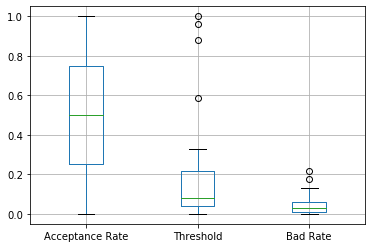

In [26]:
# Obtenemos un boxplot para ver la distribucion de los valores
strat_df[['Acceptance Rate', 'Threshold','Bad Rate',]].boxplot()
plt.show()

/Users/sgaseretto/.pyenv/versions/anaconda3-5.3.0/envs/grokking-dl/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/Users/sgaseretto/.pyenv/versions/anaconda3-5.3.0/envs/grokking-dl/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


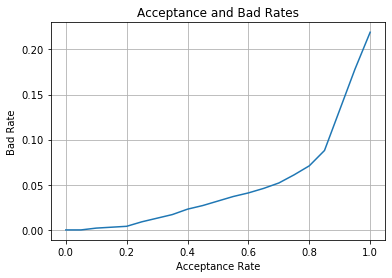

In [27]:
# Graficamos el ratio de malos prestamos en funcion del ratio de aceptacion
import sys
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'])
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [28]:
accepted_loans_list

[0,
 572,
 1175,
 1793,
 2338,
 2979,
 3534,
 4096,
 4744,
 5318,
 5910,
 6487,
 7085,
 7652,
 8242,
 8840,
 9429,
 10017,
 10605,
 11194,
 11778]

In [29]:
avg_loan_amnts

[0.0,
 8902.753496503496,
 9394.702127659575,
 9398.759063022866,
 9458.15868263473,
 9646.189996643168,
 9707.173174872665,
 9801.593017578125,
 9701.486087689713,
 9618.625423091387,
 9508.164128595601,
 9435.702173577925,
 9333.239237826394,
 9233.504312598014,
 9166.12169376365,
 9133.461538461539,
 9193.352953653623,
 9283.098732155337,
 9283.991041961339,
 9387.359299624799,
 9557.777211750721]

In [30]:
estimated_values

[0,
 5092375,
 10996525,
 16775775,
 21916975,
 28138350,
 33312700,
 38604025,
 43658600,
 48208400,
 52443950,
 56619450,
 60635100,
 64121625,
 67830225,
 71244350,
 74353725,
 76086700,
 71425225,
 64799850,
 57310450]

In [31]:
# Creamos un dataframe con los calculos sobre los valores
accepted_loans_list
avg_loan_amnts
estimated_values

values_dic = {'Num Accepted Loans': accepted_loans_list, 
              'Avg Loan Amnt': avg_loan_amnts, 
              'Estimated Value': estimated_values}
values_df = pd.DataFrame(values_dic)
values_df.head(21)

,Num Accepted Loans,Avg Loan Amnt,Estimated Value
0,0,0.000000,0
1,572,8902.753497,5092375
2,1175,9394.702128,10996525
3,1793,9398.759063,16775775
4,2338,9458.158683,21916975
5,2979,9646.189997,28138350
6,3534,9707.173175,33312700
7,4096,9801.593018,38604025
8,4744,9701.486088,43658600
9,5318,9618.625423,48208400


In [32]:
# Obtenemos nuestra tabla estrategica final
strat_df = pd.concat([strat_df, values_df], axis=1)
strat_df.head(21)

,Acceptance Rate,Threshold,Bad Rate,Num Accepted Loans,Avg Loan Amnt,Estimated Value
0,0.00,0.001,0.000,0,0.000000,0
1,0.05,0.008,0.000,572,8902.753497,5092375
2,0.10,0.017,0.002,1175,9394.702128,10996525
3,0.15,0.025,0.003,1793,9398.759063,16775775
4,0.20,0.032,0.004,2338,9458.158683,21916975
5,0.25,0.039,0.009,2979,9646.189997,28138350
6,0.30,0.045,0.013,3534,9707.173175,33312700
7,0.35,0.053,0.017,4096,9801.593018,38604025
8,0.40,0.062,0.023,4744,9701.486088,43658600
9,0.45,0.070,0.027,5318,9618.625423,48208400


Una vez obtenida la tabla estrategica, podemos obtener para qué ```Acceptance rate``` y por consiguiente para qué ```Threshold``` obtenemos el mayor Valor Estimado de los prestamos o ```Estimated Value```

In [33]:
strat_df.loc[strat_df['Estimated Value'] == np.max(strat_df['Estimated Value'])]

,Acceptance Rate,Threshold,Bad Rate,Num Accepted Loans,Avg Loan Amnt,Estimated Value
17,0.85,0.584,0.088,10017,9283.098732,76086700


## Total Expected Loss
<img src="images/total-expected-loss.png" class="center" alt="Total Expected Loss" />

In [34]:
test_pred_df.head()

,true_loan_status,prob_default,pred_loan_status,loan_amnt
0,1,0.940435,0,15000
1,1,0.922014,0,11200
2,0,0.021707,0,15000
3,0,0.026483,0,10800
4,1,0.064803,0,3000


Supongamos que para el caso de los prestamos en ```test_pred_df``` si ocurre un default, el monto total de prestamo se pierde

In [35]:
# Agregar a test_pred_df una columna de 1s para definir la loss_given_default
test_pred_df['loss_given_default'] = test_pred_df['true_loan_status'].apply(lambda x: 1 if x == 0 else 1)

In [36]:
# Print the first five rows of the data frame
test_pred_df.head()

,true_loan_status,prob_default,pred_loan_status,loan_amnt,loss_given_default
0,1,0.940435,0,15000,1
1,1,0.922014,0,11200,1
2,0,0.021707,0,15000,1
3,0,0.026483,0,10800,1
4,1,0.064803,0,3000,1


In [37]:


# Calculate the bank's expected loss and assign it to a new column
test_pred_df['expected_loss'] = test_pred_df['prob_default'] * test_pred_df['loss_given_default'] * test_pred_df['loan_amnt']

# Calculate the total expected loss to two decimal places
tot_exp_loss = round(np.sum(test_pred_df['expected_loss']),2)

# Print the total expected loss
print('Total expected loss: ', '${:,.2f}'.format(tot_exp_loss))

Total expected loss:  $27,238,564.71


Con esto podemos ver cual sería la perdida estimada utilizando el modelo actual

# Notas finales
## Los tipos de modelos construidos y maneras de trabajar con los datos en este repositorio son:
- ```Modelos de riesgo de tiempo discreto```: tambien conocido como ```Discrete-time hazard model (point in time)```, son modelos para los que todos los datos de entrenamiento y predicciones estan fijos para un momento de tiempo especifico.
- ```Structural model framework```: el modelo explica el evento de un default basado en otros factores, esto significa que los datos de entrenamiento fueron utilizados para explicar la probabilidad de default. 

## Otros modelos y tecnicas son:
- ```Through-the-cicle model (tiempo continuo)```: condiciones macro-economicas y otra condiciones son usados, pero el riesgo es visto como un evento independiente.
- ```Reduced-form model framework```: un enfoque estadistico que estima la probabilidad de default como un evento independiente poissoniano ```(Poisson-based event)```

## Por que se usaron Regresion logistica y Gradient Boosting Trees?
Otros modelos pueden ser empleados, pero en este caso se eligieron los citados porque:
- Son relativamente simples (GBT no siempre)
- Son mas fáciles de interpretar (Una red neuronal puede ser mucho mas dificil de interpretar que un modelo de GBT)
- Tienen un rendimiento aceptable

Modelos de ```caja negra``` como las redes neuronales pueden ser más precisas, pero es más dificil de explicar la toma de decisiones con esos modelos. En pasises como ```Estados Unidos``` si una casa de prestamos rechaza un prestamo a alguien y esta exige una explicación, la empresa esta obligada por ley a explicar el porqué del rechazo

## Buenas practicas
- Sobre los datos
    - Juntar tantos datos como sean posibles
    - Usar varias tecnicas para preparar y mejorar los datos (feature engineering)
    - Conocer acerca del negocio
- Complejidad del modelo
    - Modelos más complejos pueden tener mejor performance, pero pueden ser visto como cajas negras
    - Pueden haber casos donde el negocio no acepte usar un modelo tan complejo que no puedan entender
    - Modelos muy complejos pueden ser complicados de poner en produccion (valga la redundancia)